In [1]:
import cvxpy as cp
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

(CVXPY) Dec 11 08:13:32 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/melissa/miniconda3/envs/env_scRNA/lib/python3.11/site-packages/_scs_direct.cpython-311-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <A08A2CF9-B9A1-393C-A32E-68987F02C61E> /Users/melissa/miniconda3/envs/env_scRNA/lib/python3.11/site-packages/_scs_direct.cpython-311-darwin.so\n  Reason: tried: '/Users/melissa/miniconda3/envs/env_scRNA/lib/python3.11/site-packages/../../liblapack.3.dylib' (no such file), '/Users/melissa/miniconda3/envs/env_scRNA/lib/python3.11/site-packages/../../liblapack.3.dylib' (no such file), '/Users/melissa/miniconda3/envs/env_scRNA/bin/../lib/liblapack.3.dylib' (no such file), '/Users/melissa/miniconda3/envs/env_scRNA/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)")


# Ejemplo - Problema de optimización
Queremos resolver el siguiente problema de optimizacipon entera.

$\hspace{1cm}$
\begin{align*}
  \max \ &z = 5x_1 + 6x_2 \\
       & x_1+x_2 \leq 5 \\
       & 4x_1 + 7 x_2 \leq 28 \\
       & x_1, x_2 \geq 0 \\
       & x_1, x_2 \in \mathbb{Z}.
\end{align*}
$\hspace{1cm}$

In [2]:
x = cp.Variable(2, integer = True)
constr = [x[0] + x[1] <= 5, 4*x[0] + 7*x[1] <= 28, x[0] >= 0, x[1]>= 0]
z = 5*x[0] + 6*x[1]

obj = cp.Maximize(z)
prob = cp.Problem(obj, constr)

opt_val = prob.solve()
opt_val

27.0

In [3]:
solution = x.value
solution

array([3., 2.])

# Para grafos
Queremos resolver el siguiente problema de programación entera:

$\hspace{1cm}$
\begin{align*}
  \max \ &z = tr(C^tQC) \\
       & \sum_{i}C_{ij} = 1 \ \ \forall j  \\
       & C_{ij} \in \mathbb{Z}^+.
\end{align*}
$\hspace{1cm}$

Comenzaremos con un grafo sencillo. Este grafo tiene dos comunidades.

In [4]:
adjacency_matrix = np.array([
    [1, 2, 1, 0, 0, 0, 1],
    [0, 1, 1, 1, 0, 0, 0],
    [0, 0, 1, 1, 2, 3, 0],
    [1, 0, 0, 1, 2, 2, 0],
    [1, 0, 0, 0, 1, 3, 0],
    [0, 0, 4, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1]
])

n_nodes = len(adjacency_matrix)

graph = nx.DiGraph(adjacency_matrix)
weights = {(i, j): adjacency_matrix[i][j] for i in range(len(adjacency_matrix)) for j in range(len(adjacency_matrix[i])) if adjacency_matrix[i][j] > 0}
edge_weights = [weights[edge] for edge in graph.edges]

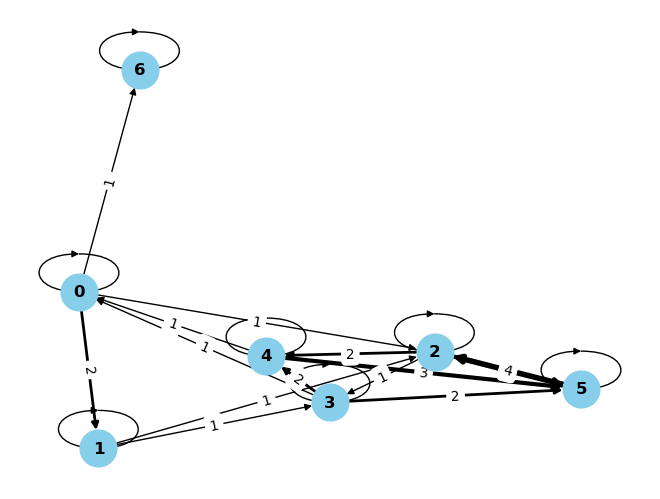

In [5]:
pos = nx.spring_layout(graph) 
nx.draw(graph, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', edge_color='black', width=edge_weights)
labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
plt.show()

/var/folders/yq/pqd8hwz96lq4v2_hsn2l7wq00000gp/T/ipykernel_19793/2132314762.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw(graph, pos, with_labels=True, font_weight='bold', node_size=700, node_color=colors, cmap=plt.cm.get_cmap('viridis'), width=edge_weights)


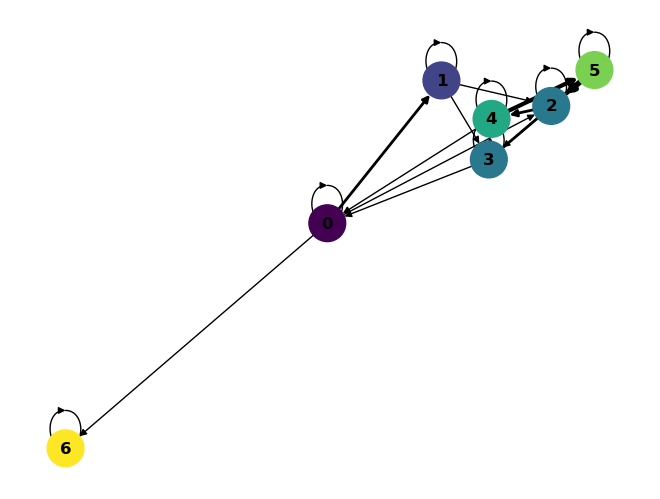

In [6]:
# Detección de comunidades usando el algoritmo de Louvain
partition = nx.community.louvain_communities(graph, resolution=1)

# Dibujar el grafo con colores según las comunidades
pos = nx.spring_layout(graph)

partition2 = {}
for indice, conjunto in enumerate(partition):
    for elemento in conjunto:
        partition2[elemento] = indice
colors = list(partition2.values())

nx.draw(graph, pos, with_labels=True, font_weight='bold', node_size=700, node_color=colors, cmap=plt.cm.get_cmap('viridis'), width=edge_weights)

# Mostrar el gráfico
plt.show()

Creamos la matriz Q. Recordemos que 
$$
q_{ij} = \frac{w_{ij}}{T} - \frac{w^{out}(i)w^{in}(j)}{T^2}
$$
En donde 
$$
w^{out}(i) = \sum_{k}w_{ik}
$$
$$
w^{in}(j) = \sum_{k}w_{kj}
$$

In [7]:
# Primero calculamos win y wout
w_in = adjacency_matrix.sum(axis = 1)
w_out = adjacency_matrix.sum(axis = 0)
T = adjacency_matrix.sum()

Q = [[adjacency_matrix[i,j]/T - w_out[i]*w_in[j]/(T**2) for j in range(n_nodes)] for i in range(n_nodes)]
Q = np.array(Q)

Ya podemos comenzar a defnir el algoritmo. Para eso, creamos la matriz C, que debe ser de dimensión KxN donde N es el número de nodos y K es el número de comunidades que quiero.

In [8]:
C = cp.Variable((2, n_nodes), integer = True)

Ahora definimos los constrints. Las filas de C suman 1 y tienen valores no negativos.

In [9]:
# Valores no negativos
constr = [ C[i,j] >= 0 for i in range(2) for j in range(n_nodes)]

# Filas suman 1
constr = constr + [sum_row == 1 for sum_row in C.sum(axis = 0)]

Definimos la función objetivo a maximizar

In [10]:
z = cp.trace(C@Q@C.T)

Objetivo

In [11]:
obj = cp.Maximize(z)

Creación del problema

In [12]:
prob = cp.Problem(obj, constr)

Solución

In [13]:
opt_val = prob.solve()

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
var75 @ [[0.02 0.05 ... -0.01 0.03]
 [-0.01 0.02 ... -0.01 -0.00]
 ...
 [-0.04 -0.03 ... -0.01 -0.01]
 [-0.01 -0.01 ... -0.01 0.03]] @ var75.T

# Intento 2: Quitar la condición de ser entero

In [102]:
# Primero calculamos win y wout
w_in = adjacency_matrix.sum(axis = 1)
w_out = adjacency_matrix.sum(axis = 0)
T = adjacency_matrix.sum()

Q = [[adjacency_matrix[i,j]/T - w_out[i]*w_in[j]/(T**2) for j in range(n_nodes)] for i in range(n_nodes)]
Q = np.array(Q)


Ya podemos comenzar a defnir el algoritmo. Para eso, creamos la matriz C, que debe ser de dimensión KxN donde N es el número de nodos y K es el número de comunidades que quiero.

In [103]:
C = cp.Variable((2, n_nodes), integer = False)

Ahora definimos los constrints. Las filas de C suman 1 y tienen valores no negativos.

In [104]:
# Valores no negativos
constr = [ C[i,j] >= 0 for i in range(2) for j in range(n_nodes)]

# Filas suman 1
constr = constr + [sum_row == 1 for sum_row in C.sum(axis = 0)]

Definimos la función objetivo a maximizar

In [105]:
z = cp.trace(C@Q@C.T)

Objetivo

In [106]:
obj = cp.Maximize(z)

Creación del problema

In [107]:
prob = cp.Problem(obj, constr)

Solución

In [108]:
opt_val = prob.solve(solver=cp.ECOS)

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
var1521 @ [[-0.01 0.07 ... -0.01 0.04]
 [-0.01 -0.01 ... -0.01 0.00]
 ...
 [-0.05 -0.03 ... -0.05 0.00]
 [-0.01 -0.00 ... -0.01 0.00]] @ var1521.T

In [12]:
import torch
import numpy as np
from torch.autograd import Variable

# Hiperparámetros de SGD
learning_rate = 0.01
num_iterations = 1000

# Datos del problema (ajusta según tus necesidades)
n_nodes = 10
Q_np = np.eye(n_nodes)  # Matriz de ejemplo, ajusta según tu problema

# Convertir a tensores de PyTorch
Q = torch.tensor(Q_np, dtype=torch.float32, requires_grad=True)
C = torch.randn((2, n_nodes), dtype=torch.float32, requires_grad=True)

# SGD
for iteration in range(num_iterations):        
    
    # Calcular el gradiente
    z = -torch.trace(torch.softmax(C, dim = 0) @ Q @ torch.softmax(C, dim = 0).t())
    z.backward()

    # Actualizar C en la dirección opuesta al gradiente
    with torch.no_grad():
        C -= learning_rate * C.grad
        #C = torch.softmax(C, dim = 0)

    C.grad.zero_()

    # Imprimir el valor de la función objetivo cada cierto número de iteraciones
    if iteration % 100 == 0:
        print(f"Iteración {iteration}: Valor de la función objetivo: {z.item()}")

# Obtener la solución final
final_solution = C.detach().numpy()

print("\nSolución final:")
print(final_solution)


Iteración 0: Valor de la función objetivo: -6.714545249938965
Iteración 100: Valor de la función objetivo: -7.1861090660095215
Iteración 200: Valor de la función objetivo: -7.637287616729736
Iteración 300: Valor de la función objetivo: -8.042484283447266
Iteración 400: Valor de la función objetivo: -8.397586822509766
Iteración 500: Valor de la función objetivo: -8.691546440124512
Iteración 600: Valor de la función objetivo: -8.919381141662598
Iteración 700: Valor de la función objetivo: -9.090408325195312
Iteración 800: Valor de la función objetivo: -9.219094276428223
Iteración 900: Valor de la función objetivo: -9.317752838134766

Solución final:
[[-2.1698623  -0.65412974  2.2867122   2.1882253  -1.8464888  -2.363664
  -0.75824785 -2.0138268   1.8162005  -1.4788789 ]
 [ 1.261264    2.2423997  -1.2463267  -1.9010185   1.6684598   0.99619406
   2.7158103   1.0597397  -2.2488127   1.9578241 ]]
